In [16]:
import bayes3d as b
import numpy as np
import jax.numpy as jnp
import jax

import utils

In [26]:
import importlib
importlib.reload(utils)
from utils import load_img, scale_remove_and_setup_renderer, add_meshes_to_renderer, c2f_jit, cps_to_pose, get_grids

In [18]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


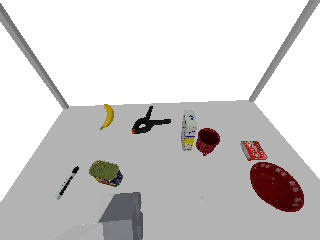

In [19]:
rgbd = load_img("problems/img1.pickle")
b.get_rgb_image(rgbd.rgb)

In [20]:
rgbd_scaled_down, obs_img, table_pose, cloud, depth_im = scale_remove_and_setup_renderer(rgbd, scaling_factor=0.5)

b.clear()
b.show_cloud("Obs without table or too-far points", obs_img.reshape(-1,3))
b.show_pose("table", table_pose)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (160, 128, 1024)


In [21]:
add_meshes_to_renderer()

In [64]:
grid_param_sequence = [
    (0.6, jnp.pi, (20, 20, 20)),
    (0.2, jnp.pi * 3/4, (15, 15, 15)),
    (0.1, jnp.pi * 1/2, (15, 15, 15)),
    (0.05, jnp.pi * 1/3, (15,15,15)),
    (0.02, jnp.pi * 1/4, (9,9,51)),
    # (0.01, jnp.pi * 1/5, (15,15,15)),
    # (0.01, 0.0, (31,31,1)),
    # (0.05, 0.0, (31,31,1))
]
width_sequence = None # [0.04, 0.04, 0.04, 0.04, 0.02]

In [65]:
cps, indices, poses = utils.run_inference(table_pose, obs_img, grid_param_sequence, width_sequence=width_sequence, n_objs_to_add=6) #, cps = cps, indices = indices)

Fitting object 1...
Fitting object 2...
Fitting object 3...
Fitting object 4...
Fitting object 5...
Fitting object 6...


In [66]:
b.clear()
b.show_cloud("obs", obs_img.reshape(-1,3))
b.show_pose("table", table_pose)
for i in range(len(poses)):
    b.show_trimesh(f"{i}", b.RENDERER.meshes[indices[i]])
    b.set_pose(f"{i}", poses[i])

In [51]:
import os
import glob
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
list = glob.glob(os.path.join(model_dir, "*.ply"))

# get numbers out of array of strings like `'/home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000007.ply'`
ycb_order = [int(s.split("/")[-1].split("_")[-1].split(".")[0]) for s in list]

def ycb_index_to_render_index(ycb_index):
    return np.where(np.array(ycb_order) == ycb_index)[0][0]

In [52]:
banana_idx = ycb_index_to_render_index(10)

In [53]:
key = jax.random.PRNGKey(31)
# cps = jnp.zeros((0,3))
# indices = jnp.array([], dtype=jnp.int32)
low, high = jnp.array([-0.2, -0.2, -jnp.pi]), jnp.array([0.2, 0.2, jnp.pi])
key = jax.random.split(key,2)[0]

grid = get_grids(grid_param_sequence)[0]
next_index = banana_idx
face_child = 3
potential_indices = jnp.concatenate([indices, jnp.array([next_index])])
potential_cps = jnp.concatenate([cps, jax.random.uniform(key, shape=(1,3,),minval=low, maxval=high)])
cps_expanded = jnp.repeat(potential_cps[None,...], grid.shape[0], axis=0) # (g, n, 3)
number = len(cps)
cps_expanded = cps_expanded.at[:,number,:].set(cps_expanded[:,number,:] + grid) # (g, n, 3)
poses = utils.cps_to_pose_parallel(cps_expanded, potential_indices, table_pose, face_child)
rendered_images = b.RENDERER.render_many(poses, potential_indices)[...,:3] # (g, h, w, 3)
scores = utils.score_vmap(rendered_images, obs_img, 0.06)
best_idx = jnp.argmax(scores) # jnp.argsort(scores)[-4]
indices = potential_indices
cps = cps_expanded[best_idx]

In [54]:
b.clear()
b.show_cloud("obs", obs_img.reshape(-1,3))
b.show_pose("table", table_pose)

final_poses = cps_to_pose(cps, indices, table_pose, face_child)
for i in range(len(final_poses)):
    b.show_trimesh(f"{i}", b.RENDERER.meshes[indices[i]])
    b.set_pose(f"{i}", final_poses[i])

# for i in range(poses.shape[0]):
#     if i % 15 == 0:
#         b.show_pose(f"pose{i}", poses[i, 6, :])